# (c.i)

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [99]:
train = pd.read_csv("Q2_Train_Data.csv")
train_emotion = train['emotion']
train_pixels = train['pixels'].str.split(' ', expand = True)
train_pixels = train_pixels.apply(pd.to_numeric)

In [100]:
vali = pd.read_csv("Q2_Validation_Data.csv")
vali_emotion = vali['emotion']
vali_pixels = vali['pixels'].str.split(' ', expand=True)
vali_pixels = vali_pixels.apply(pd.to_numeric)

In [101]:
test = pd.read_csv("Q2_Test_Data.csv")
test_emotion = test['emotion']
test_pixels = test['pixels'].str.split(' ', expand=True)
test_pixels = test_pixels.apply(pd.to_numeric)

In [102]:
# Preprocessing: Normalize the images.
train_pixels = (train_pixels / 255) - 0.5
vali_pixels = (vali_pixels / 255) - 0.5
test_pixels = (test_pixels / 255) - 0.5

In [103]:
train_pixels_fnn = train_pixels.copy()
vali_pixels_fnn = vali_pixels.copy()
test_pixels_fnn = test_pixels.copy()

In [104]:
from keras import backend
backend.clear_session()

In [105]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [106]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

In [107]:
from keras.utils import to_categorical
import time

In [108]:
number_pixels = train_pixels.shape[1]
number_emotion = train_emotion.unique().shape[0]

--------------------------------------------------------------------------------------                                 
Hyperparameters:                                                                                                       
{'dropout_prob': 0.1677625462791072, 'network_config': (64, 128, 64), 'optimizer': 'Adam'}                             
Accuracy on training sets: 0.4924                                                                                      
Accuracy on validation sets: 0.4411                                                                                    
Running time: 48.5358 s                                                                                                
Number of parameters: 164551                                                                                           
--------------------------------------------------------------------------------------                                 
  0%|                                   

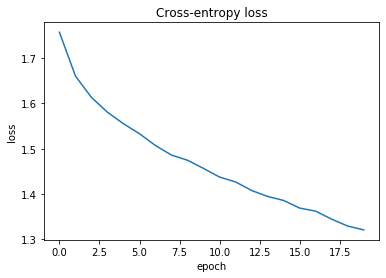

--------------------------------------------------------------------------------------                                 
Hyperparameters:                                                                                                       
{'dropout_prob': 0.254216968380646, 'network_config': (32, 64, 32), 'optimizer': 'Adam'}                               
Accuracy on training sets: 0.4192                                                                                      
Accuracy on validation sets: 0.4090                                                                                    
Running time: 45.9782 s                                                                                                
Number of parameters: 78183                                                                                            
--------------------------------------------------------------------------------------                                 
 20%|█████████▌                         

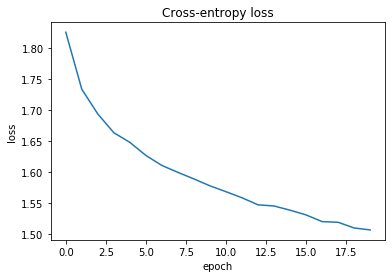

--------------------------------------------------------------------------------------                                 
Hyperparameters:                                                                                                       
{'dropout_prob': 0.29093578003899523, 'network_config': (64, 64), 'optimizer': 'Adam'}                                 
Accuracy on training sets: 0.4496                                                                                      
Accuracy on validation sets: 0.4257                                                                                    
Running time: 44.9866 s                                                                                                
Number of parameters: 152135                                                                                           
--------------------------------------------------------------------------------------                                 
 40%|███████████████████▏               

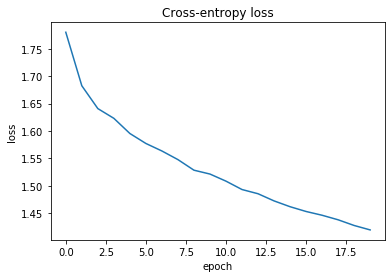

--------------------------------------------------------------------------------------                                 
Hyperparameters:                                                                                                       
{'dropout_prob': 0.10716143754813606, 'network_config': (128, 256, 128), 'optimizer': 'Adam'}                          
Accuracy on training sets: 0.6166                                                                                      
Accuracy on validation sets: 0.4550                                                                                    
Running time: 53.1552 s                                                                                                
Number of parameters: 361863                                                                                           
--------------------------------------------------------------------------------------                                 
 60%|████████████████████████████▊      

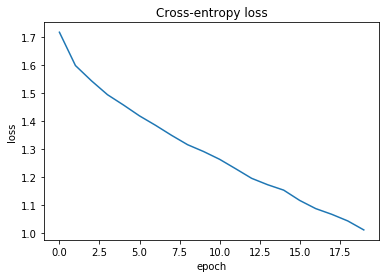

--------------------------------------------------------------------------------------                                 
Hyperparameters:                                                                                                       
{'dropout_prob': 0.3421010631910505, 'network_config': (32, 64, 32), 'optimizer': 'sgd'}                               
Accuracy on training sets: 0.2853                                                                                      
Accuracy on validation sets: 0.3068                                                                                    
Running time: 45.0868 s                                                                                                
Number of parameters: 78183                                                                                            
--------------------------------------------------------------------------------------                                 
 80%|███████████████████████████████████

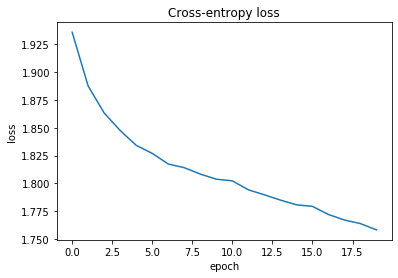

100%|█████████████████████████████████████████████████| 5/5 [04:00<00:00, 48.00s/trial, best loss: -0.4550013840198517]


In [111]:
def optimize_fnn(hyperparameter):
    backend.clear_session()
    fnn_model = Sequential()
    
    first_layer = True
    for layer_size in hyperparameter['network_config']:
        if first_layer:
            fnn_model.add(Dense(layer_size, input_dim = number_pixels, activation='relu'))
            first_layer = False
        else:
            fnn_model.add(Dense(layer_size, activation='relu'))

        fnn_model.add(Dropout(hyperparameter['dropout_prob']))

    fnn_model.add(Dense(number_emotion, activation='softmax'))
    fnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'])

    train_X, train_y = train_pixels, to_categorical(train_emotion)
    valid_X, valid_y = vali_pixels, to_categorical(vali_emotion)

    start = time.time()
    fnn_history = fnn_model.fit(train_pixels_fnn, to_categorical(train_emotion), epochs=20, batch_size=256, verbose=0)
    end = time.time()

    performance_fnn = fnn_model.evaluate(vali_pixels_fnn, to_categorical(vali_emotion), verbose=0)

    print("--------------------------------------------------------------------------------------")
    print("Hyperparameters: ", (hyperparameter))
    print("Accuracy on training sets: %.4f" % (fnn_history.history['accuracy'][-1]))
    print("Accuracy on validation sets: %.4f" % (performance_fnn[1]))
    print("Running time: %.4f s" % (end-start))
    print("Number of parameters: %d" % (fnn_model.count_params()))
    print("--------------------------------------------------------------------------------------")

    plt.plot(fnn_history.history['loss'])
    plt.title('Cross-entropy loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    return({"status": STATUS_OK, "loss": -1*performance_fnn[1], "model":fnn_model})

# Define search space for hyper-parameters
space = {
    # The kernel_size for convolutions:
    'network_config': hp.choice('network_config', [[32,32],[32,64,32],[64,64],[64,128,64],[128,256,128]]),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.35),
    # Choice of optimizer 
    'optimizer': hp.choice('optimizer', ['Adam','sgd'])
}

trials = Trials()

# Find the best hyperparameters
best = fmin(
        optimize_fnn,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=5,
    )


# (c.ii)

--------------------------------------------------------------------------------------
Hyperparameters:  {'dropout_prob': 0.10716143754813606, 'network_config': (128, 256, 128), 'optimizer': 'Adam'}
Accuracy on training sets: 0.6223
Accuracy on validation sets: 0.4600
Running time: 53.7366 s
Number of parameters: 361863
--------------------------------------------------------------------------------------


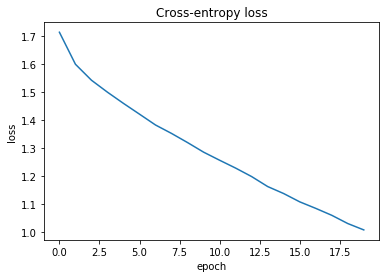

Test Accuracy:  0.4485929310321808


In [112]:
best_hyper_fnn = space_eval(space,best)
fnn_tuned = optimize_fnn(best_hyper_fnn)
performance_fnn = fnn_tuned['model'].evaluate(test_pixels_fnn, to_categorical(test_emotion), verbose=0)
print("Test Accuracy: ", performance_fnn[1])